In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from torchvision.datasets import CIFAR10
from torchvision.transforms import Normalize, Resize, Compose, CenterCrop, InterpolationMode
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from astra.torch.models import EfficientNet, CNN
from astra.torch.al import RandomAcquisition, RandomStrategy
from astra.torch.utils import train_fn, predict_class

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

device = "cuda"


In [2]:
eff_transform = EfficientNet_B0_Weights.DEFAULT.transforms()
# print(eff_transform)
# transform = Compose([Resize(256, interpolation=InterpolationMode.BICUBIC), Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# plt.imshow(transform(train_inputs[0:5])[0, 0].numpy())
# plt.imshow(transform(eff_transform(train_inputs[0:5]))[0, 0].numpy())

## Prepare the dataset

In [3]:
train_data = CIFAR10(root="./data", train=True, download=True)
test_data = CIFAR10(root="./data", train=False, download=True)

train_inputs = torch.tensor(train_data.data).permute(0, 3, 1, 2).float() / 255
train_outputs = torch.tensor(train_data.targets).long()

test_inputs = torch.tensor(test_data.data).permute(0, 3, 1, 2).float() / 255
test_outputs = torch.tensor(test_data.targets).long()

print(train_inputs.shape, train_inputs.type)
print(train_outputs.shape, train_outputs.type)

Files already downloaded and verified
Files already downloaded and verified
torch.Size([50000, 3, 32, 32]) <built-in method type of Tensor object at 0x7f8939963050>
torch.Size([50000]) <built-in method type of Tensor object at 0x7f8939960050>


## Divide into train, test and pool

In [4]:
train_size = 100

idx = torch.randperm(len(train_inputs))
train_indices = idx[:train_size]
pool_indices = idx[train_size:]
test_indices = torch.arange(len(test_inputs))
print(len(train_indices), len(pool_indices), len(test_indices))

100 49900 10000


## Test the baselines

### Fitted on initial train

In [5]:
model = EfficientNet(
    efficientnet_b0, EfficientNet_B0_Weights.DEFAULT, output_dim=10
).to(device)

result = train_fn(
    model,
    train_inputs[train_indices].to(device),
    train_outputs[train_indices].to(device),
    loss_fn=nn.CrossEntropyLoss(),
    lr=1e-4,
    n_epochs=50,
    batch_size=32,
    enable_tqdm=True,  # Use tqdm for progress bar
)

  0%|          | 0/200 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Loss: 0.619238: 100%|██████████| 200/200 [00:07<00:00, 25.17it/s]


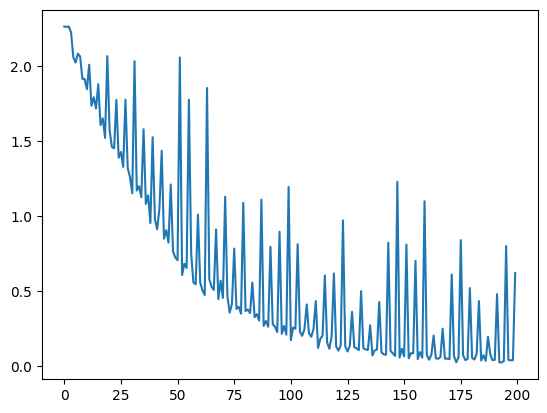

In [6]:
plt.plot(result["iter_losses"])

In [7]:
model.eval()

for name, indices, inputs, outputs in zip(["train", "test"], [train_indices, test_indices], [train_inputs, test_inputs], [train_outputs, test_outputs]):
    y_preds = predict_class(model, inputs[indices].to(device), batch_size=128).cpu()
    print(f"{name} accuracy", accuracy_score(outputs[indices], y_preds))

100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


train accuracy 1.0


  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 79/79 [00:02<00:00, 37.37it/s]

test accuracy 0.5627


### Fitted on train + pool

In [8]:
model = EfficientNet(
    efficientnet_b0, EfficientNet_B0_Weights.DEFAULT, output_dim=10
).to(device)
# model = CNN(224, 5, 3, [16, 32, 64, 128, 256], [512], 10, activation=nn.ReLU(), dropout=0.0).to(device)

result = train_fn(
    model,
    train_inputs.to(device),
    train_outputs.to(device),
    loss_fn=nn.CrossEntropyLoss(),
    lr=1e-4,
    n_epochs=2,
    batch_size=32,
    enable_tqdm=True,  # Use tqdm for progress bar
)

  0%|          | 0/3126 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Loss: 0.122305: 100%|██████████| 3126/3126 [01:57<00:00, 26.57it/s]


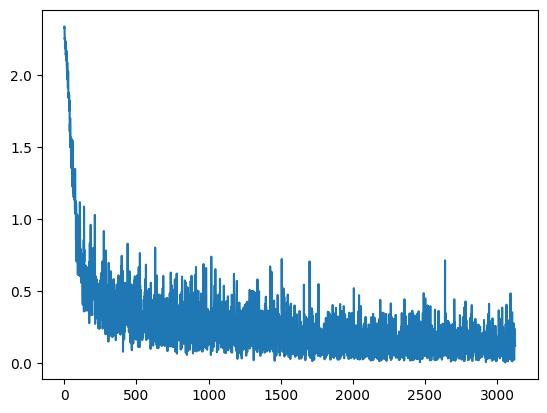

In [9]:
plt.plot(result["iter_losses"])

In [10]:
model.eval()

for name, indices, inputs, outputs in zip(["train", "test"], [torch.cat([train_indices, pool_indices]), test_indices], [train_inputs, test_inputs], [train_outputs, test_outputs]):
    y_preds = predict_class(model, inputs[indices].to(device), batch_size=128).cpu()
    print(f"{name} accuracy", accuracy_score(outputs[indices], y_preds))

100%|██████████| 391/391 [00:09<00:00, 39.16it/s]


train accuracy 0.99148


  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 79/79 [00:01<00:00, 39.82it/s]

test accuracy 0.9602


## Active Learning

In [11]:
al_iterations = 10
n_query_samples = 20

inputs = train_inputs[train_indices].to(device)
outputs = train_outputs[train_indices].to(device)

model = EfficientNet(
    efficientnet_b0, EfficientNet_B0_Weights.DEFAULT, output_dim=10
).to(device)

result = train_fn(
    model,
    inputs,
    outputs,
    loss_fn=nn.CrossEntropyLoss(),
    lr=1e-4,
    n_epochs=30,
    batch_size=64,
    enable_tqdm=True,  # Use tqdm for progress bar
)

acquisition = RandomAcquisition()
strategy = RandomStrategy(acquisition, train_inputs, train_outputs)

queried_indices = torch.tensor([], dtype=torch.long)
test_accuracy = []
train_accuracy = []
train_loss = []
for iteration in range(al_iterations):
    # Query samples to be annotated
    result = strategy.query(model, pool_indices=pool_indices, batch_size=64, n_query_samples=n_query_samples)
    indices = result["RandomAcquisition"]
    
    # Update indices
    queried_indices = torch.cat([queried_indices, indices])
    pool_indices = np.setdiff1d(pool_indices.numpy(), indices.numpy())
    pool_indices = torch.from_numpy(pool_indices).long()
    
    # New inputs
    inputs = train_inputs[torch.cat([train_indices, queried_indices])].to(device)
    outputs = train_outputs[torch.cat([train_indices, queried_indices])].to(device)
    
    # Fine-tune model
    result = train_fn(
        model,
        inputs,
        outputs,
        loss_fn=nn.CrossEntropyLoss(),
        lr=1e-4,
        n_epochs=5,
        batch_size=64,
        enable_tqdm=True,  # Use tqdm for progress bar
    )
    
    train_loss.append(result["epoch_losses"][-1])
    
    # Train accuracy
    y_preds = predict_class(model, inputs, batch_size=128).cpu()
    train_accuracy.append(accuracy_score(outputs.cpu(), y_preds))
    
    # Test accuracy
    y_preds = predict_class(model, test_inputs[test_indices].to(device), batch_size=128).cpu()
    test_accuracy.append(accuracy_score(test_outputs[test_indices], y_preds))
    
    print(f"AL iteration {iteration}. {len(queried_indices)} samples queried. Test accuracy {test_accuracy[-1]}")

  0%|          | 0/60 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 0. 20 samples queried. Test accuracy 0.5514


  0%|          | 0/15 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 1. 40 samples queried. Test accuracy 0.5966


  0%|          | 0/15 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 2. 60 samples queried. Test accuracy 0.6654


  0%|          | 0/15 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 3. 80 samples queried. Test accuracy 0.6873


  0%|          | 0/20 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 4. 100 samples queried. Test accuracy 0.6945


  0%|          | 0/20 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 5. 120 samples queried. Test accuracy 0.6995


  0%|          | 0/20 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 6. 140 samples queried. Test accuracy 0.7145


  0%|          | 0/25 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 7. 160 samples queried. Test accuracy 0.7073


  0%|          | 0/25 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 8. 180 samples queried. Test accuracy 0.7141


  0%|          | 0/25 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  0%|          | 0/79 [00:00<?, ?it/s]/home/patel_zeel/miniconda3/envs/torch_gpu_py311/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias pa

AL iteration 9. 200 samples queried. Test accuracy 0.7286


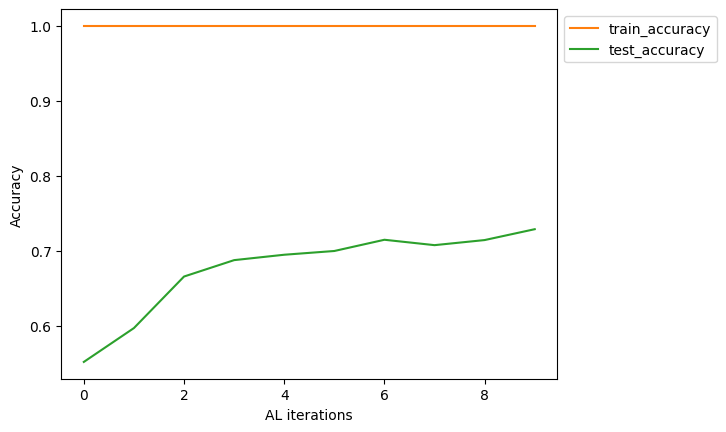

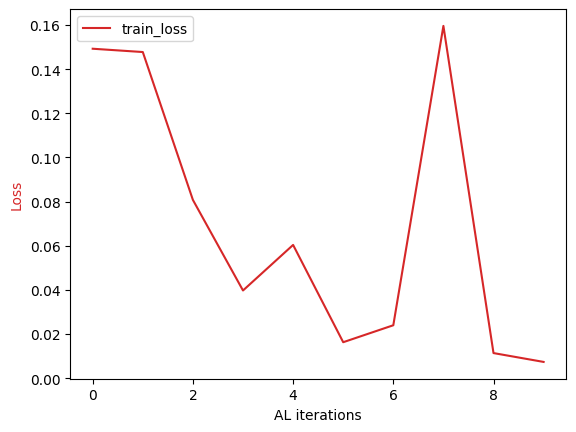

In [12]:
plt.plot(train_accuracy, label="train_accuracy", color="C1")
plt.plot(test_accuracy, label="test_accuracy", color="C2")
plt.xlabel("AL iterations")
plt.ylabel("Accuracy")
plt.legend(bbox_to_anchor=(1, 1))

plt.figure()
plt.plot(train_loss, label="train_loss", color="C3")
plt.ylabel("Loss", color="C3")
plt.xlabel("AL iterations")
plt.legend()